# This trains a ResNet50 for classification on the skin cancer images

In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from ResNet_baseline import HDF5Dataset

## Load data and preprocess

In [2]:
# Load metadata
metadata = pd.read_csv("train-metadata.csv")
hdf5 = h5py.File("train-image.hdf5", "r")

# Sample balanced malignant and benign
malignant_ids = metadata[metadata["target"] == 1].sample(n=393, random_state=42)["isic_id"].tolist()
benign_ids = metadata[metadata["target"] == 0].sample(n=393, random_state=42)["isic_id"].tolist()

def load_images(ids):
    images = []
    labels = []
    for image_id in ids:
        image = hdf5[image_id][()]
        image = np.frombuffer(image, dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (128, 128))
        images.append(image)
        labels.append(1 if image_id in malignant_ids else 0)
    return images, labels

images_mal, labels_mal = load_images(malignant_ids)
images_ben, labels_ben = load_images(benign_ids)

# Combine and split
all_images = np.array(images_mal + images_ben)
all_labels = np.array(labels_mal + labels_ben)

X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.1, stratify=all_labels, random_state=42)

/tmp/ipykernel_1000647/1558046119.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("train-metadata.csv")


In [3]:
train_dataset = HDF5Dataset(X_train, y_train, augment=True)
val_dataset = HDF5Dataset(X_val, y_val, augment=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

## Train

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
os.makedirs("checkpoints", exist_ok=True)
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # binary classification (logit)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

/home/mperform/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mperform/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
num_epochs = 20
train_losses, val_losses = [], []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

In [7]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # [B, 1]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # === Validation ===
    model.eval()
    val_loss = 0
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_auc = roc_auc_score(targets, preds)
    
    # Threshold predictions at 0.5
    pred_labels = (np.array(preds) >= 0.5).astype(int)
    true_labels = np.array(targets).astype(int)

    val_acc = accuracy_score(true_labels, pred_labels)
    val_precision = precision_score(true_labels, pred_labels)
    val_recall = recall_score(true_labels, pred_labels)
    val_f1 = f1_score(true_labels, pred_labels)

    print(f"Epoch {epoch+1}: Acc = {val_acc:.4f}, Precision = {val_precision:.4f}, Recall = {val_recall:.4f}, F1 = {val_f1:.4f}") 
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'val_auc': val_auc
    }, f"checkpoints/resnet50_epoch_{epoch+1}.pth")

Epoch 1/20: 100%|██████████| 23/23 [00:02<00:00,  8.97it/s]


Epoch 1: Acc = 0.6582, Precision = 0.7000, Recall = 0.5385, F1 = 0.6087


Epoch 2/20: 100%|██████████| 23/23 [00:00<00:00, 23.05it/s]


Epoch 2: Acc = 0.7215, Precision = 0.7297, Recall = 0.6923, F1 = 0.7105


Epoch 3/20: 100%|██████████| 23/23 [00:00<00:00, 24.78it/s]


Epoch 3: Acc = 0.7215, Precision = 0.7179, Recall = 0.7179, F1 = 0.7179


Epoch 4/20: 100%|██████████| 23/23 [00:00<00:00, 24.93it/s]


Epoch 4: Acc = 0.7722, Precision = 0.8000, Recall = 0.7179, F1 = 0.7568


Epoch 5/20: 100%|██████████| 23/23 [00:00<00:00, 25.05it/s]


Epoch 5: Acc = 0.7722, Precision = 0.7838, Recall = 0.7436, F1 = 0.7632


Epoch 6/20: 100%|██████████| 23/23 [00:00<00:00, 24.78it/s]


Epoch 6: Acc = 0.7975, Precision = 0.8286, Recall = 0.7436, F1 = 0.7838


Epoch 7/20: 100%|██████████| 23/23 [00:00<00:00, 25.18it/s]


Epoch 7: Acc = 0.8101, Precision = 0.8750, Recall = 0.7179, F1 = 0.7887


Epoch 8/20: 100%|██████████| 23/23 [00:00<00:00, 24.62it/s]


Epoch 8: Acc = 0.7848, Precision = 0.8056, Recall = 0.7436, F1 = 0.7733


Epoch 9/20: 100%|██████████| 23/23 [00:00<00:00, 25.19it/s]


Epoch 9: Acc = 0.7975, Precision = 0.8108, Recall = 0.7692, F1 = 0.7895


Epoch 10/20: 100%|██████████| 23/23 [00:00<00:00, 25.14it/s]


Epoch 10: Acc = 0.8101, Precision = 0.8529, Recall = 0.7436, F1 = 0.7945


Epoch 11/20: 100%|██████████| 23/23 [00:00<00:00, 25.16it/s]


Epoch 11: Acc = 0.7468, Precision = 0.7568, Recall = 0.7179, F1 = 0.7368


Epoch 12/20: 100%|██████████| 23/23 [00:00<00:00, 25.21it/s]


Epoch 12: Acc = 0.7848, Precision = 0.8235, Recall = 0.7179, F1 = 0.7671


Epoch 13/20: 100%|██████████| 23/23 [00:00<00:00, 25.24it/s]


Epoch 13: Acc = 0.7848, Precision = 0.8438, Recall = 0.6923, F1 = 0.7606


Epoch 14/20: 100%|██████████| 23/23 [00:00<00:00, 25.26it/s]


Epoch 14: Acc = 0.7848, Precision = 0.8438, Recall = 0.6923, F1 = 0.7606


Epoch 15/20: 100%|██████████| 23/23 [00:00<00:00, 25.20it/s]


Epoch 15: Acc = 0.7722, Precision = 0.8000, Recall = 0.7179, F1 = 0.7568


Epoch 16/20: 100%|██████████| 23/23 [00:00<00:00, 25.21it/s]


Epoch 16: Acc = 0.7595, Precision = 0.7941, Recall = 0.6923, F1 = 0.7397


Epoch 17/20: 100%|██████████| 23/23 [00:00<00:00, 25.31it/s]


Epoch 17: Acc = 0.7722, Precision = 0.8182, Recall = 0.6923, F1 = 0.7500


Epoch 18/20: 100%|██████████| 23/23 [00:00<00:00, 24.64it/s]


Epoch 18: Acc = 0.7595, Precision = 0.7941, Recall = 0.6923, F1 = 0.7397


Epoch 19/20: 100%|██████████| 23/23 [00:00<00:00, 24.47it/s]


Epoch 19: Acc = 0.7848, Precision = 0.8235, Recall = 0.7179, F1 = 0.7671


Epoch 20/20: 100%|██████████| 23/23 [00:00<00:00, 25.26it/s]


Epoch 20: Acc = 0.7848, Precision = 0.8438, Recall = 0.6923, F1 = 0.7606


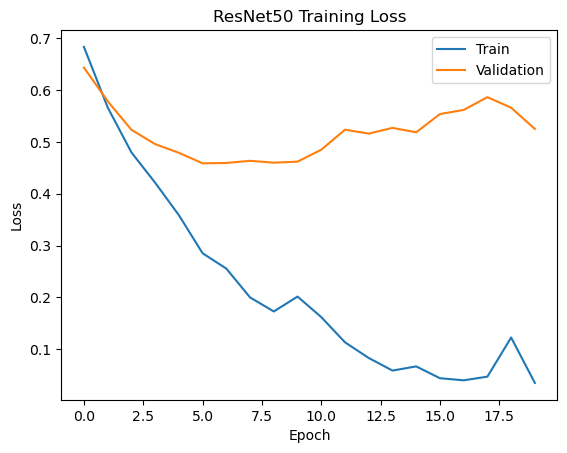

In [8]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 Training Loss")
plt.legend()
plt.savefig("resnet50_loss_curve.png")

## Testing

In [13]:
# model = models.resnet50(pretrained=False)
# model.fc = nn.Linear(model.fc.in_features, 1)
# model.load_state_dict(torch.load("checkpoints/resnet50_epoch_20.pth", weights_only=False))
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
test_metadata = pd.read_csv("test-metadata.csv")
test_hdf5 = h5py.File("test-image.hdf5", "r")

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Store predictions
results = []

for i in tqdm(range(len(test_metadata))):
    image_id = test_metadata.iloc[i]["isic_id"]
    image_data = test_hdf5[image_id][()]
    image = np.frombuffer(image_data, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = transform(image).unsqueeze(0).to(device)  # [1, 3, 128, 128]

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()

    results.append((image_id, prob))

100%|██████████| 3/3 [00:00<00:00, 41.36it/s]


In [15]:
results_df = pd.DataFrame(results, columns=["isic_id", "predicted_probability"])
results_df["predicted_label"] = (results_df["predicted_probability"] >= 0.5).astype(int)
results_df.to_csv("test_predictions.csv", index=False)